**Mapping closure for $f_B$ in 1D using a Monte-Carlo Implementation**

This notebook introduces the mapping closure developed by (Chen, H. 1989, Pope, S.B. 1991) and discusses how it can be applied to the problem of turbulent scalar mixing. In contrast to these works which consider a one-point pdf, usually in the context of homogeneous isotropic turbulence, we consider the *global pdf* describing the contents of an arbitrary control volume.


**Content**

We first import all the packages we need to run this example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Evolution equation for the PDF**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial F}{\partial t} = -\mathbb{E}_Y[ \Gamma \nabla^2 Y ] \frac{\partial F}{\partial y},
\end{equation}

and

\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial y} \left( \mathbb{E}_Y[ \Gamma \nabla^2 Y ] f \right).
\end{equation}

As $f(y,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

The idea behind this closure relies on Gaussian random fields. What makes these "random" fields particularly useful is:
- They are completely defined by their mean and covariance: 
\begin{equation}
    \mu = \mathbb{E}[\theta(\mathbf{z})], \quad \rho(r) = \mathbb{E}[\theta(\mathbf{z})\theta(\mathbf{z} + \mathbf{e}r)] - \mu^2,
\end{equation}
- Allow the calculate explicity the conditional expectation
\begin{equation}
lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle,
\end{equation}

and the fact that multiple different field can have the same global PDF.


**Mapping Closure**

Based on the properties of the Gaussian random field the idea is therefore to find a mapping 
\begin{equation}
\tilde{Y}(\mathbf{x},t) = \mathscr{Y}(\theta(\mathbf{x} J(t)),t),
\end{equation}
such that we can express the CDF $F$ in terms of the cumulative Gaussian $G$ 
\begin{equation}
F(\mathscr{Y}(\eta,t),t) = G(\eta).
\end{equation}

Differentiating the last equation we obtain
\begin{equation}
\frac{ \partial F}{\partial t} = -\frac{ \partial \mathscr{Y}}{\partial t} \frac{ \partial F}{\partial y}.
\end{equation}
which can then be expressed as
\begin{equation}
\frac{\partial \mathscr{Y}}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] = \Gamma \underbrace{\frac{J^2(t)}{\lambda_{\theta}^2}}_{= 1/\tau} \left( \frac{\partial^2 \mathscr{Y} }{\partial \eta^2} - \eta \frac{\partial \mathscr{Y} }{\partial \eta} \right).
\end{equation}

**Particle Implementation**

Although we can solve this equation as a PDE on a grid using a standard method such as finite-difference it is also possible to use a particle method. Let $g(\eta)$ be the PDF of the random variable $\theta_t$ be generated an Ornstein-Uhlenbeck process:

\begin{equation}
  d \theta_{t} = -\frac{\theta_{t}}{T} d t +\left(\frac{1}{T} \right)^{1/2} d W_{t},
\end{equation}

and $Y_{t}=\mathscr{Y}(\theta_t,t)$, if follows from Ito's lemma implies that

\begin{equation}
  d Y_{t} = \frac{\partial \mathscr{Y}_{t} }{\partial t} dt + \frac{1}{T} \left( -\eta \frac{\partial \mathscr{Y}_{t}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^{2}} \right) dt + \frac{\partial \mathscr{Y}_{t}}{\partial \eta} \left( \frac{1}{T} \right)^{1/2} d W_{t},
\end{equation}

where $\eta$ is the sample-space (or dummy) variable corresponding to the random variable $\theta_t$. Setting $T = \tau = 1$ and substituting for $\frac{\partial \mathscr{Y}_{t} }{\partial t}$ then gives the full system as

\begin{align*} 
 d \theta_{t} &= -\theta_{t} d t + d W_{t},\\
 d \mathscr{Y}(\theta_{t} , t) &= \left( -\eta \partial_{\eta} \mathscr{Y} + \partial^2_{\eta} \mathscr{Y} \right) dt + \left( \partial_{\eta} \mathscr{Y} \right) d W_{t},
\end{align*}

where it is understood that derivatives are to be evaluated at $\eta = \theta_t$.

To determine $Y_t = \mathscr{Y}(\theta_t,t)$ and its derivatives requires that $F_Y(\mathscr{Y}(\eta,t),t) = G(\eta)$ is satisfied. Solving for the inverse CDF $F^{-1}_Y(p,t)$ we can determine

\begin{equation}
\mathscr{Y}(\eta,t) = F^{-1}_Y( G(\eta), t),
\end{equation}

as a function of $\eta$. Differentiating $F(\mathscr{Y}(\eta,t),t) = G(\eta)$ then gives 

\begin{equation}
\frac{\partial \mathscr{Y}_{t}}{\partial \eta} = \frac{g(\eta)}{f_Y(\mathscr{Y}(\eta,t),t)},
\end{equation}

which differentiated again respect to $\eta$ gives

\begin{equation}
\frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^2} = - \eta \frac{g}{f_Y} - \frac{g}{f^2_Y} \frac{\partial \mathscr{Y}_{t}}{\partial \eta} = - \frac{g}{f_Y} \left( \eta  + \frac{g}{f^2_Y} \right),
\end{equation}

an expression that is a function of $g, f_Y$ and $\eta$ only.

Substituting for the derivatives in terms of $g,f_Y$ then gives

\begin{align*} 
 d \theta_{t} &= -\theta_{t} d t + d W_{t},\\
 d \mathscr{Y}(\theta_{t} , t) &= \left( \frac{g}{f_Y} \right) \left( \left[ -2 \theta_{t}  + \frac{g}{f^2_Y} \right] dt + d W_{t} \right),
\end{align*}


In [2]:
# from KDEpy import FFTKDE

from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import integrate

def cdf_using_kde(data, range=None, grid_size=100):
    """
    Compute the empirical CDF using Kernel Density Estimation (KDE).

    Parameters:
    - data: numpy array of float values
    - grid_size: number of points in the CDF grid

    Returns:
    - x_grid: sorted data points (evaluation grid)
    - cdf_values: cumulative density function values
    """
    kde = gaussian_kde(data)
    if range != None:
        x_grid = np.linspace(range[0], range[-1], grid_size)  # Define evaluation grid
    else:
        x_grid = np.linspace(min(data),max(data), grid_size)  # Define evaluation grid
    pdf_values = kde(x_grid)  # Evaluate PDF on the grid
    cdf_values = np.cumsum(pdf_values)  # Compute cumulative sum
    cdf_values /= cdf_values[-1]  # Normalize to make it a valid CDF
    return x_grid, cdf_values


def cdf_using_hist(data, range=None, bins=64):
   
    f, x = np.histogram(data, bins=bins, range=range, density=True)
    x = .5*(x[1:] + x[:-1])
    F = integrate.cumulative_trapezoid(y=f,x=x,initial=0)
    #F = np.cumsum(f)  # Compute cumulative sum
    #F /= F[-1]

    return x, F, f


def global_terms(Y_data, θ_data, range, N=64, plot=True):
    """
    Calculates f, η, Y, dY, ddY
    """
    
    # y, F_Y = cdf_using_kde(Y_data, range)
    # η, G = cdf_using_kde(θ_data)

    y, F_Y, f_Y = cdf_using_hist(Y_data,range=range,bins=N)
    η, G_θ, g_θ = cdf_using_hist(θ_data,range=None,bins=N)

    # Inverse CDF
    Q_Y = interp1d(F_Y, y, bounds_error=False, fill_value="extrapolate")
    
    # Compute the map
    #Y = Q_Y(G_θ) # gaussian_filter1d(Q_Y(G), sigma=2)

    Y = np.interp(x=G_θ, xp=F_Y, fp=y)


    # Differentiate
    from derivatives import grad, laplacian
    dY = 0*Y
    dY[1:-1]  = (grad(η)@Y)[1:-1]
    ddY = laplacian(η)@Y

    if plot ==True:
        fig1, ax = plt.subplots(nrows=1,ncols=3)
        #ax[0].plot(y[1:-1],(grad(y)@F_Y)[1:-1])
        ax[0].plot(y,f_Y)
        ax[0].set_title('PDF')
        
        ax[1].plot(y,F_Y)
        ax[1].set_title('CDF')
        p = np.linspace(0,1,N)
        
        ax[2].plot(p,Q_Y(p))
        ax[2].set_title('Inverse CDF')
        plt.show()

        fig2, ax = plt.subplots(nrows=1,ncols=3)
        ax[0].plot(η,Y)
        ax[0].set_title(r'$\mathscr{Y}_t(\eta)$')
        
        ax[1].plot(η,dY)
        ax[1].set_title(r'$\partial_{\eta} \mathscr{Y}_t(\eta)$')
        
        ax[2].plot(η,ddY)
        ax[2].set_title(r'$\partial^2_{\eta} \mathscr{Y}_t(\eta)$')
        plt.show()

    # Interpolate dY,ddY on the θ_data
    dY_t  = np.interp(x=θ_data, xp=η, fp=dY)
    ddY_t = np.interp(x=θ_data, xp=η, fp=ddY)

    Y = np.interp(x=θ_data, xp=η, fp=Y  )
    g = np.interp(x=θ_data, xp=η, fp=g_θ)
    f = np.interp(x=Y,      xp=y, fp=f_Y)


    return f, g, dY_t, ddY_t

/home/pmannix/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/pmannix/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


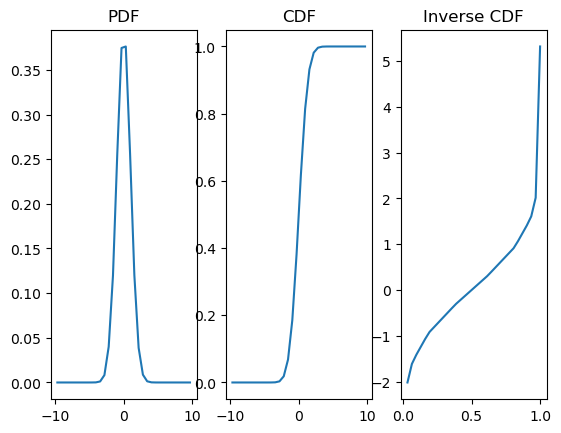

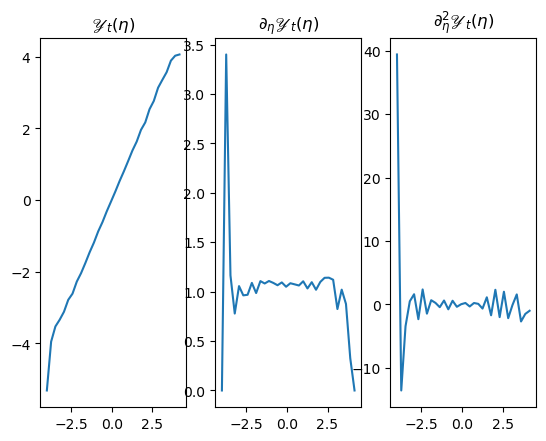

/tmp/ipykernel_4061/2755066603.py:46: RuntimeWarning: divide by zero encountered in divide
  Y_new = Y[:, n-1] +  (g/f)*(         (-2*θ[:, n-1] - (g/(f**2)) ) * dt  +  dW_t[:,n-1] )


t = 1.000000e-02 



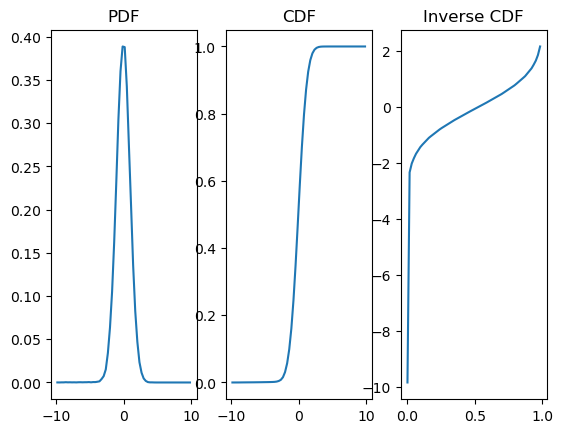

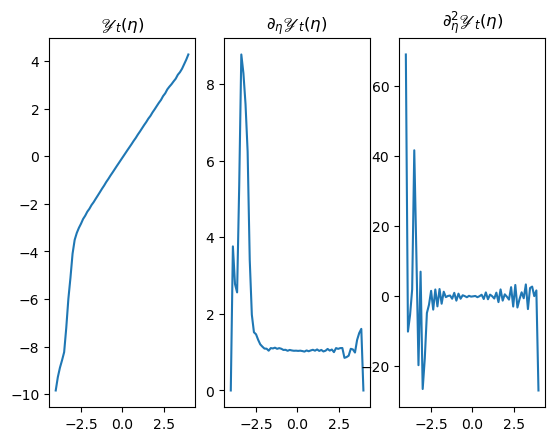

t = 2.000000e-02 



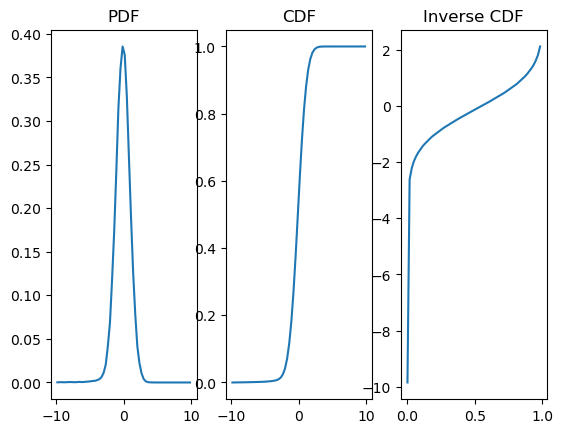

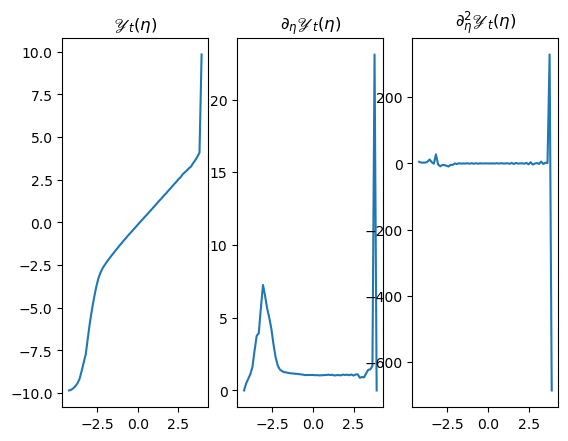

t = 3.000000e-02 



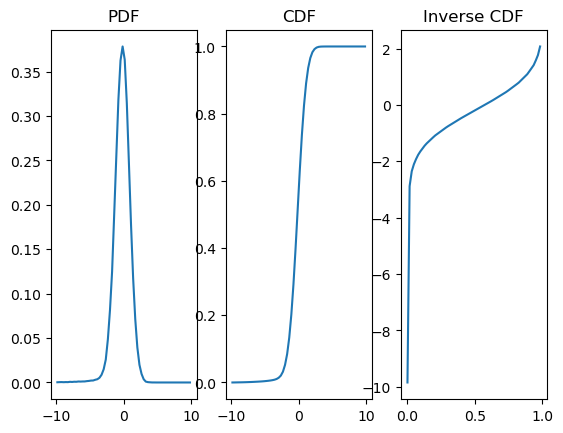

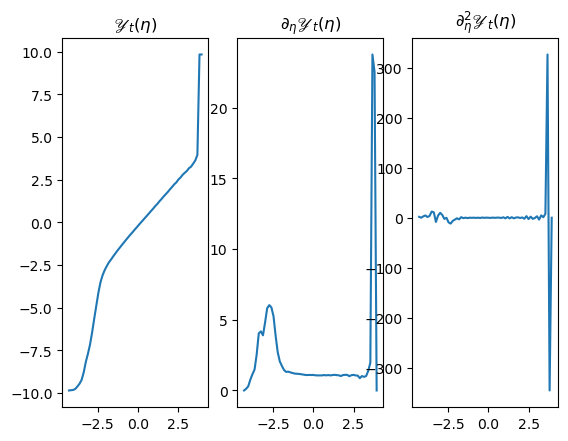

t = 4.000000e-02 



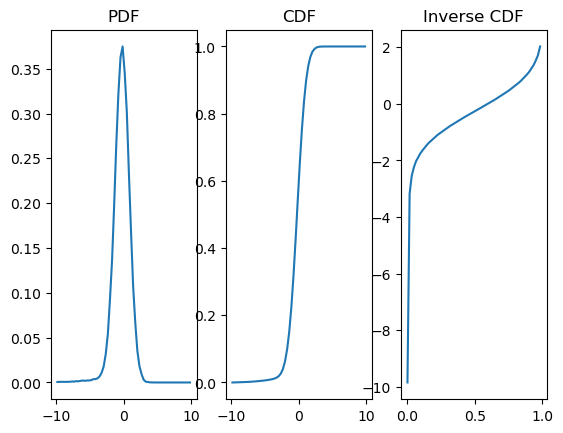

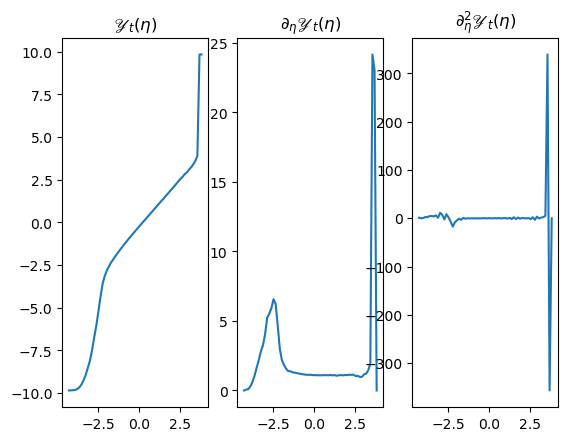

t = 5.000000e-02 



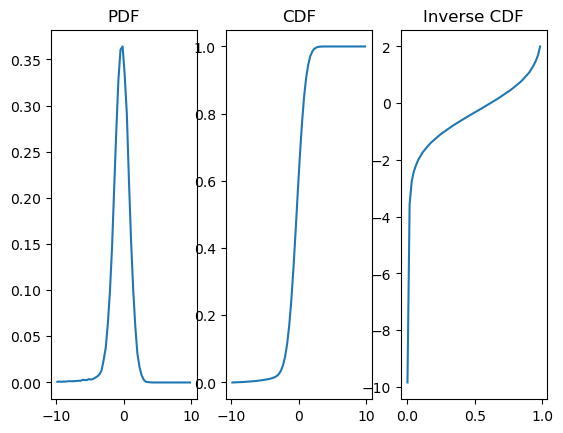

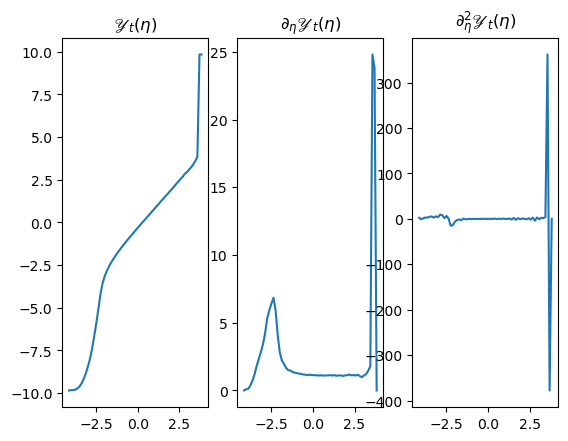

t = 6.000000e-02 



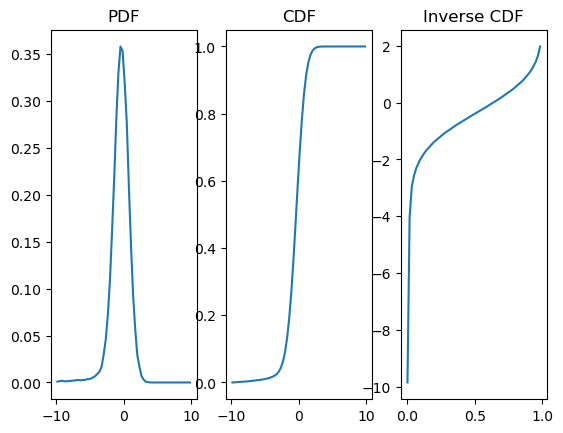

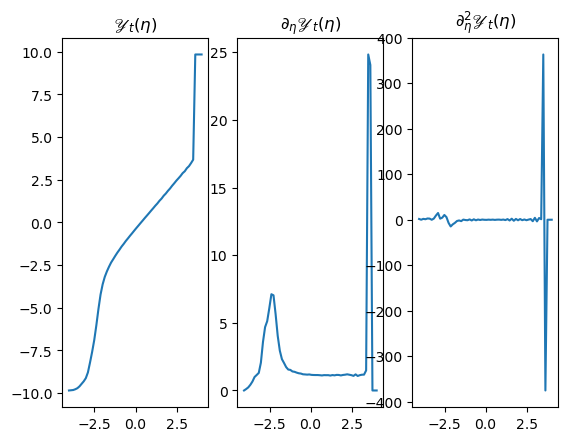

t = 7.000000e-02 



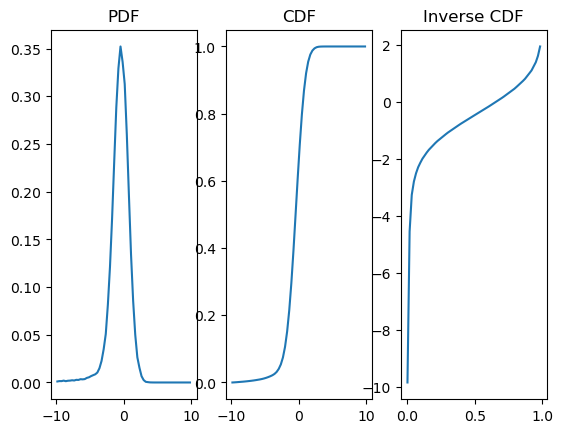

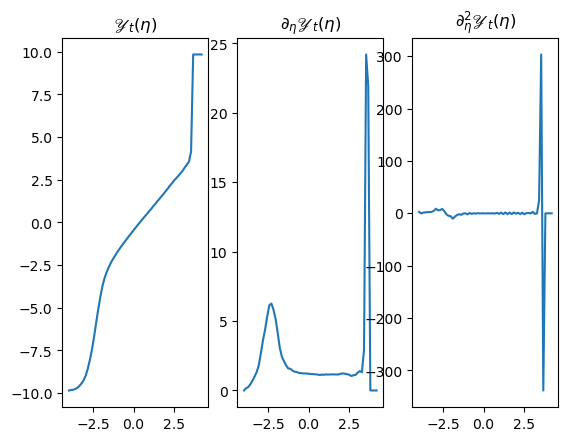

t = 8.000000e-02 



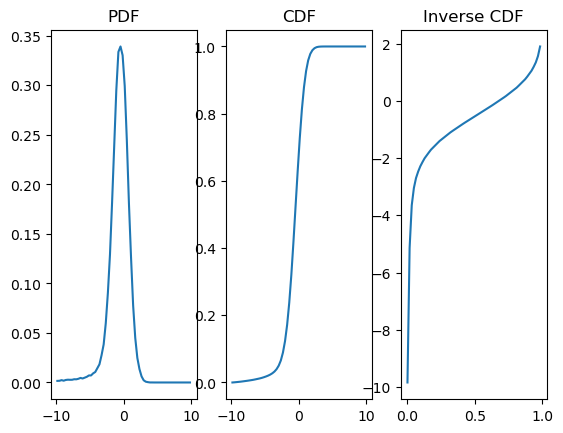

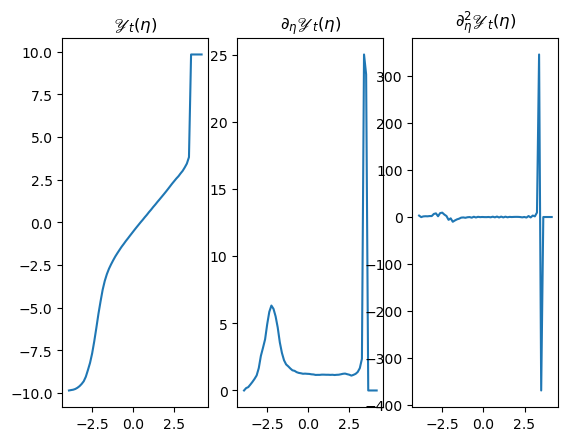

t = 9.000000e-02 



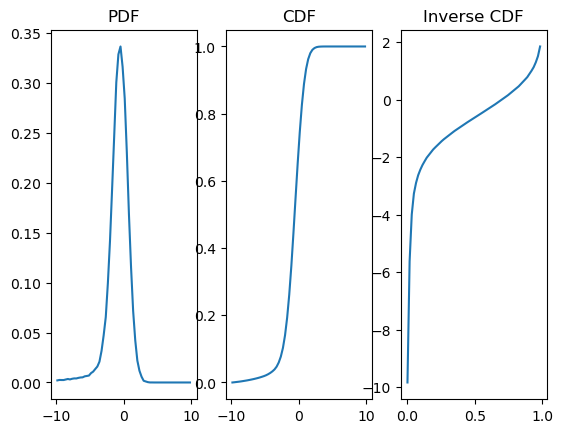

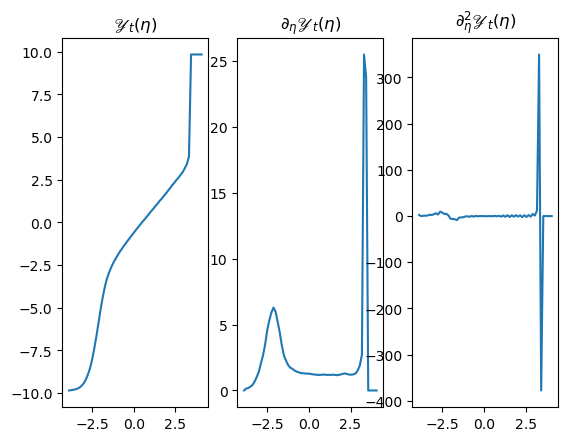

In [3]:
from scipy.stats import norm

# Parameters
num_particles = 10**5  # Number of Monte Carlo samples
num_steps = 10**3     # Time steps
dt = 1e-04         # Time step size

Y_min = -10
Y_max =  10

# Brownian increments
dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps))  

# Container
θ = np.zeros((num_particles, num_steps))
Y = np.zeros((num_particles, num_steps))

# Initial conditions
θ[:,0] = np.random.normal(0, 1, num_particles) 

# Initial condition (Normal distribution)
Y[:,0] = np.random.normal(0, 1, num_particles)  

# Half of the particles to +1 and the other to -1
#Y[:num_particles//2,0] = 1
#Y[num_particles//2:,0] =-1

# Calculate derivatives
f,g,dY_t, ddY_t = global_terms(Y[:,0], θ[:,0], range=(Y_min,Y_max), N=32, plot=True)

# Euler Maruyama
for n in range(1, num_steps):

    if n % (num_steps/10) == 0:
        print('t = %e \n'%(n*dt))
        plot=True
    else:
        plot=False

    # Calculate derivatives
    f,g, dY_t, ddY_t = global_terms(Y[:,n-1], θ[:,n-1], range=[Y_min,Y_max], N=64, plot=plot) #
    
    # Update particles
    θ[:, n] = θ[:, n-1] -  θ[:, n-1] * dt  +  dW_t[:,n-1]
    #Y[:, n] = Y[:, n-1] +  (ddY_t - dY_t*θ[:, n-1]) * dt + dY_t * dW_t[:,n-1,1]
    Y_new = Y[:, n-1] +  (g/f)*(         (-2*θ[:, n-1] - (g/(f**2)) ) * dt  +  dW_t[:,n-1] )

    Y_new[np.isnan(Y_new)] = 0
    Y[:, n] = Y_new

    # Apply Reflecting/bcs
    # Y[:, n] = np.where(Y[:, n] > Y_max, Y_max - (Y[:, n] - Y_max), Y[:, n]) # Reflect back inside
    # Y[:, n] = np.where(Y[:, n] < Y_min, Y_min + (Y_min - Y[:, n]), Y[:, n]) # Reflect back inside


# # Estimate the probability density function at final time step using KDE
# b_values = np.linspace(-1.2, 1.2, 100)
# kde = gaussian_kde(b[:, -1])
# pdf_values = kde(b_values)

# # Plot the Monte Carlo histogram and estimated density
# plt.figure(figsize=(8, 5))
# plt.hist(b[:, -1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
# plt.plot(b_values, pdf_values, 'r-', label="Kernel Density Estimation (KDE)")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.title("Monte Carlo Solution of Fokker-Planck")
# plt.legend()
# plt.show()